In [1]:
import pandas as pd
import numpy as np
import random

random.seed(1)

data = pd.read_excel("SBA_Loan_data_.xlsx", "Sheet1")
print("loaded")

print "Number of samples:", data.shape[0]
print data.dtypes
# data.head()

# Drop bad data
data = data[data.LoanStatus != 'CANCLD']
data = data[data.LoanStatus != 'EXEMPT']

# Convert loan status to a boolean
# data["Default?"] = data['LoanStatus'] == 'CHGOFF'

# Drop 'Program' column
data = data.drop('Program', axis = 1)

# Specify that NAICS + ZIP codes and 'ApprovalFiscalYear' are categorical
data[['NaicsCode','BorrZip','CDC_Zip','ApprovalFiscalYear']] = data[['NaicsCode','BorrZip','CDC_Zip','ApprovalFiscalYear']].fillna("MISSING")
data[['NaicsCode','BorrZip','CDC_Zip','ApprovalFiscalYear']] = data[['NaicsCode','BorrZip','CDC_Zip','ApprovalFiscalYear']].astype(str)

# data = data.drop('BorrStreet', axis = 1)
# data = data.drop('CDC_Street', axis = 1)

# Fill in the empty entries under 'ChargeOffDate' with NA/not applicable
data.update(data['ChargeOffDate'].fillna("NA"))

data[['GrossApproval']] = data[['GrossApproval']].astype(float)

# Make sure ThirdPartyDollars is considered a quantitative
data["ThirdPartyDollars"] = data["ThirdPartyDollars"].astype(float)

# We need to drop InitialInterestRate because it's either completely missing or always 3%.
# More importantly, it causes an error when attempting to impute.
data = data.drop('InitialInterestRate', axis = 1)

# Fill missing categorical data with a MISSING tag

cats = data.select_dtypes(include=['object'])
cats = cats.fillna("MISSING")
data.update(cats)

print data.dtypes
data.head()

loaded
Number of samples: 147423
Program                            int64
BorrName                          object
BorrStreet                        object
BorrCity                          object
BorrState                         object
BorrZip                            int64
CDC_Name                          object
CDC_Street                        object
CDC_City                          object
CDC_State                         object
CDC_Zip                          float64
ThirdPartyLender_Name             object
ThirdPartyLender_City             object
ThirdPartyLender_State            object
ThirdPartyDollars                float64
GrossApproval                      int64
ApprovalDate              datetime64[ns]
ApprovalFiscalYear                 int64
DeliveryMethod                    object
subpgmdesc                        object
InitialInterestRate              float64
TermInMonths                       int64
NaicsCode                        float64
NaicsDescription        

,BorrName,BorrStreet,BorrCity,BorrState,BorrZip,CDC_Name,CDC_Street,CDC_City,CDC_State,CDC_Zip,...,subpgmdesc,TermInMonths,NaicsCode,NaicsDescription,ProjectCounty,ProjectState,BusinessType,LoanStatus,ChargeOffDate,GrossChargeOffAmount
0,ROBERT G. FIELDS AND MARY D. F,55 & RICHLAND,KANSAS CITY,KS,66106,Avenue Area Incorporated,3324 Emerald Lane,Jefferson City,MO,65109.0,...,Sec. 504 - Loan Guarantees - Private Sector Fi...,12,MISSING,MISSING,WYANDOTTE,KS,INDIVIDUAL,PIF,NA,0.0
1,CANDLELAMP COMPANY,3454 NIKI WAY,RIVERSIDE,CA,92507,CDC Small Business Finance Cor,2448 Historic Decatur,San Diego,CA,92106.0,...,Sec. 504 - Loan Guarantees - Private Sector Fi...,240,MISSING,MISSING,RIVERSIDE,CA,INDIVIDUAL,PIF,NA,0.0
2,"NATIONAL COMPOSITES, INC.",2303 N. BENDIX DRIVE,SOUTH BEND,IN,46628,Business Development Corporati,218 W. Washington Street,South Bend,IN,46601.0,...,Sec. 504 - Loan Guarantees - Private Sector Fi...,120,MISSING,MISSING,ST JOSEPH,IN,CORPORATION,PIF,NA,0.0
3,WENDY'S OF HARRISBURG,OUTLOT A. TR. 45N & SMALL ST,HARRISBURG,IL,62946,Small Business Growth Corporat,2401 West White Oaks Drive,Springfield,IL,62704.0,...,Sec. 504 - Loan Guarantees - Private Sector Fi...,240,MISSING,MISSING,SALINE,IL,CORPORATION,CHGOFF,2003-03-28 00:00:00,0.0
6,"ROCKY MTN EMPLOYE BENEFTS, INC",3200 S. 700 E.,SALT LAKE CITY,UT,84106,Mountain West Small Business F,2595 East 3300 South,Salt Lake City,UT,84109.0,...,Sec. 504 - Loan Guarantees - Private Sector Fi...,240,MISSING,MISSING,SALT LAKE,UT,CORPORATION,PIF,NA,0.0


In [2]:
# Process a table of ZIP code ranges for each state found online
file = open("zipcodes.csv","r")
zip_ref = [line.strip().split(",") for line in file]
zip_ref = {line[2] : (int(line[3]),int(line[4])) for line in zip_ref}
# Deal with corner cases ("GU" = Guam and "VI" = Virgin Islands)
zip_ref["MISSING"] = (1,-1)
zip_ref["GU"] = (96910,96932)
zip_ref["VI"] = (801, 851)

# Make a record we can edit while iterating
zips = data[['BorrState','BorrZip','CDC_State','CDC_Zip']]

for index, series in data.iterrows():
    # Load ranges
    borr_bot, borr_top = zip_ref[series['BorrState']]
    cdc_bot, cdc_top = zip_ref[series['CDC_State']]

    # Check borrower zip code
    if(series['BorrZip'] == "MISSING"):
        borr_zip = -1
    else:
        borr_zip = float(series['BorrZip']) 
        
    # Check CDC zip code
    if(series['CDC_Zip'] == "MISSING"):
        cdc_zip = -1
    else:
        cdc_zip = float(series['CDC_Zip']) 

    # compare with ranges
    if borr_bot > borr_zip or borr_zip > borr_top:
        zips.at[index,'BorrZip'] = "MISSING"
    if borr_bot > cdc_zip or cdc_zip > borr_top:
        zips.at[index,'CDC_Zip'] = "MISSING"
data.update(zips)

# data.to_csv("output/output_with_missing.csv")

In [3]:
# combining the time variant features 
hpi_by_state = pd.read_csv("HPI_State.csv",sep="\t")
cpi_bread = pd.read_csv("CPI_Bread_White.csv",sep="\t")
sp500_yearly = pd.read_csv("SP500_yearly_return.csv")

hpi_by_state['Year'] = hpi_by_state['Year'].astype(str)
cpi_bread['Year'] = cpi_bread['Year'].astype(str)
sp500_yearly['Year'] = cpi_bread['Year'].astype(str)

sba_w_macroecon = pd.merge(data,sp500_yearly,left_on='ApprovalFiscalYear',\
                           right_on='Year',how='left').drop("Year", axis=1).\
                            rename(index=str, columns={"Average yearly return": "SP500_Yearly_Return"})

sba_w_macroecon = pd.merge(sba_w_macroecon,cpi_bread,left_on='ApprovalFiscalYear',\
                           right_on='Year',how='left').drop("Year", axis=1).\
                            rename(index=str, columns={"Average": "CPI"})
    
sba_w_macroecon = pd.merge(sba_w_macroecon,hpi_by_state,left_on=\
                           ['ProjectState','ApprovalFiscalYear'],\
                           right_on=['State Abbreviation','Year'],how='left').\
                            drop(["State Abbreviation","Year","FIPS"], axis=1)

# sba_w_macroecon.head()

In [4]:
data = sba_w_macroecon

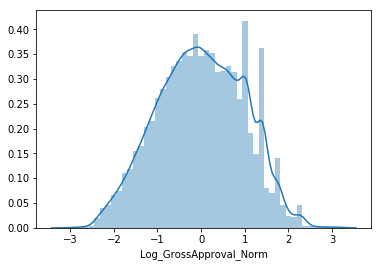

In [5]:
# log transform Gross_Approval, S&P500, lacking GSP, SBA_Approval for now
data['Log_GrossApproval'] = np.log(data['GrossApproval'])
# normalize
data['Log_GrossApproval_Norm'] = (data['Log_GrossApproval'] - np.mean(data['Log_GrossApproval']))/(0.01 + np.std(data['Log_GrossApproval']))
# data['Log_GrossApproval_Norm'].head()
data = data.drop('Log_GrossApproval', axis = 1)
# Visualize the Log_GrossApproval_Norm here with plots

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.distplot(data['Log_GrossApproval_Norm']);


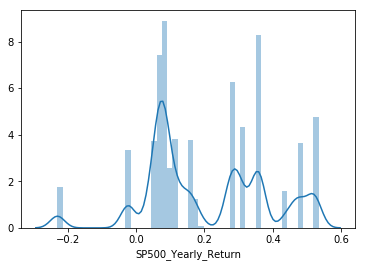

In [6]:
# log transform Gross_Approval, SBA_Approval, S&P500, lacking GSP for now - 
# not going to log transform s&p500 data - too small after and negative values
# data['Log_SP500'] = np.log(data['SP500_Yearly_Return'])
# Visualize
%matplotlib inline
sns.distplot(data['SP500_Yearly_Return']);
# sns.distplot(data['HPI']);

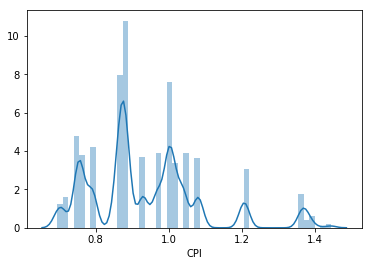

In [7]:
%matplotlib inline
sns.distplot(data['CPI']);

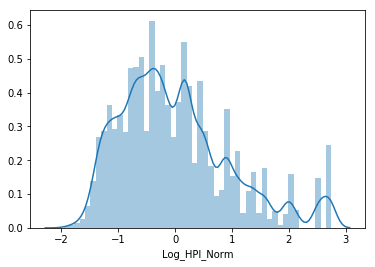

In [8]:
data['HPI'] = data['HPI'].fillna(np.mean(data['HPI']))
data['Log_HPI'] = np.log(data['HPI'])
# normalize
data['Log_HPI_Norm'] = (data['Log_HPI'] - np.mean(data['Log_HPI']))/(0.01 + np.std(data['Log_HPI']))
data = data.drop('Log_HPI', axis = 1)
%matplotlib inline
sns.distplot(data['Log_HPI_Norm']);

In [9]:
data['ThirdPartyDollars'] = data['ThirdPartyDollars'].fillna(0)
data['ThirdPartyDollars'].unique()
# data['Log_ThirdPartyDollars'] = np.log(data['ThirdPartyDollars'])
# normalize
data.head()

,BorrName,BorrStreet,BorrCity,BorrState,BorrZip,CDC_Name,CDC_Street,CDC_City,CDC_State,CDC_Zip,...,ProjectState,BusinessType,LoanStatus,ChargeOffDate,GrossChargeOffAmount,SP500_Yearly_Return,CPI,HPI,Log_GrossApproval_Norm,Log_HPI_Norm
0,ROBERT G. FIELDS AND MARY D. F,55 & RICHLAND,KANSAS CITY,KS,66106,Avenue Area Incorporated,3324 Emerald Lane,Jefferson City,MO,MISSING,...,KS,INDIVIDUAL,PIF,NA,0.0,0.180581,0.695,186.24,-0.877936,-1.724167
1,CANDLELAMP COMPANY,3454 NIKI WAY,RIVERSIDE,CA,92507,CDC Small Business Finance Cor,2448 Historic Decatur,San Diego,CA,92106.0,...,CA,INDIVIDUAL,PIF,NA,0.0,0.180581,0.695,470.90,-1.326195,0.479768
2,"NATIONAL COMPOSITES, INC.",2303 N. BENDIX DRIVE,SOUTH BEND,IN,46628,Business Development Corporati,218 W. Washington Street,South Bend,IN,46601.0,...,IN,CORPORATION,PIF,NA,0.0,0.180581,0.695,220.51,-0.298051,-1.322856
3,WENDY'S OF HARRISBURG,OUTLOT A. TR. 45N & SMALL ST,HARRISBURG,IL,62946,Small Business Growth Corporat,2401 West White Oaks Drive,Springfield,IL,62704.0,...,IL,CORPORATION,CHGOFF,2003-03-28 00:00:00,0.0,0.180581,0.695,250.58,-0.293151,-1.019129
4,"ROCKY MTN EMPLOYE BENEFTS, INC",3200 S. 700 E.,SALT LAKE CITY,UT,84106,Mountain West Small Business F,2595 East 3300 South,Salt Lake City,UT,84109.0,...,UT,CORPORATION,PIF,NA,0.0,0.180581,0.695,211.10,-0.974087,-1.426473


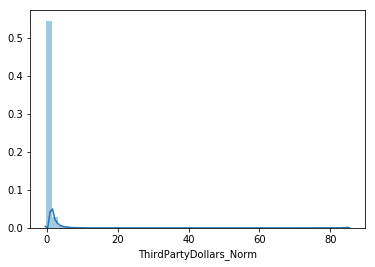

In [10]:
data['ThirdPartyDollars_Norm'] = (data['ThirdPartyDollars'] - np.mean(data['ThirdPartyDollars']))/(0.01 + np.std(data['ThirdPartyDollars']))
# data = data.drop('Log_ThirdPartyDollars', axis = 1)
# data['Log_ThirdPartyDollars_Norm'] = np.log(data['ThirdPartyDollars_Norm'])
%matplotlib inline
sns.distplot(data['ThirdPartyDollars_Norm']);

In [11]:
# adding explanatory variables
# adding Indicator: Term an integer multiple of a year
data['TermMultipleYear'] = (data['TermInMonths'] % 12 == 0)
repeat = [0]*len(data)
borr = dict()
for idx, val in data['BorrName'].iteritems():
    if val not in borr:
        borr[val] = 1
    else:
        repeat[idx] = 1
data['RepeatBorrower'] = repeat
data['BankStateneqBorrowerState'] = (data['BorrState'] != data['CDC_State'])
data['ProjectStateneqBorrowerState'] = (data['BorrState'] != data['ProjectState'])
data['2DigitNaics'] = data['NaicsCode'].astype(str).str[:2]
print data.shape
print data.dtypes
data.head()

(54807, 39)
BorrName                                object
BorrStreet                              object
BorrCity                                object
BorrState                               object
BorrZip                                 object
CDC_Name                                object
CDC_Street                              object
CDC_City                                object
CDC_State                               object
CDC_Zip                                 object
ThirdPartyLender_Name                   object
ThirdPartyLender_City                   object
ThirdPartyLender_State                  object
ThirdPartyDollars                      float64
GrossApproval                          float64
ApprovalDate                    datetime64[ns]
ApprovalFiscalYear                      object
DeliveryMethod                          object
subpgmdesc                              object
TermInMonths                             int64
NaicsCode                               object
N

,BorrName,BorrStreet,BorrCity,BorrState,BorrZip,CDC_Name,CDC_Street,CDC_City,CDC_State,CDC_Zip,...,CPI,HPI,Log_GrossApproval_Norm,Log_HPI_Norm,ThirdPartyDollars_Norm,TermMultipleYear,RepeatBorrower,BankStateneqBorrowerState,ProjectStateneqBorrowerState,2DigitNaics
0,ROBERT G. FIELDS AND MARY D. F,55 & RICHLAND,KANSAS CITY,KS,66106,Avenue Area Incorporated,3324 Emerald Lane,Jefferson City,MO,MISSING,...,0.695,186.24,-0.877936,-1.724167,-0.377884,True,0,True,False,MI
1,CANDLELAMP COMPANY,3454 NIKI WAY,RIVERSIDE,CA,92507,CDC Small Business Finance Cor,2448 Historic Decatur,San Diego,CA,92106.0,...,0.695,470.90,-1.326195,0.479768,-0.377884,True,0,False,False,MI
2,"NATIONAL COMPOSITES, INC.",2303 N. BENDIX DRIVE,SOUTH BEND,IN,46628,Business Development Corporati,218 W. Washington Street,South Bend,IN,46601.0,...,0.695,220.51,-0.298051,-1.322856,-0.377884,True,0,False,False,MI
3,WENDY'S OF HARRISBURG,OUTLOT A. TR. 45N & SMALL ST,HARRISBURG,IL,62946,Small Business Growth Corporat,2401 West White Oaks Drive,Springfield,IL,62704.0,...,0.695,250.58,-0.293151,-1.019129,-0.377884,True,0,False,False,MI
4,"ROCKY MTN EMPLOYE BENEFTS, INC",3200 S. 700 E.,SALT LAKE CITY,UT,84106,Mountain West Small Business F,2595 East 3300 South,Salt Lake City,UT,84109.0,...,0.695,211.10,-0.974087,-1.426473,-0.377884,True,0,False,False,MI


In [12]:
# dropping features
columns = data.columns.tolist()
columns.remove('BorrName')
columns.remove('BorrStreet')
columns.remove('CDC_Name')
columns.remove('CDC_Street')
columns.remove('ThirdPartyLender_Name')
columns.remove('NaicsDescription')
columns.remove('GrossApproval')
columns.remove('NaicsCode')
columns.remove('ThirdPartyDollars')
columns.remove('HPI')
data_processed = data[columns]
data_processed.dtypes

BorrCity                                object
BorrState                               object
BorrZip                                 object
CDC_City                                object
CDC_State                               object
CDC_Zip                                 object
ThirdPartyLender_City                   object
ThirdPartyLender_State                  object
ApprovalDate                    datetime64[ns]
ApprovalFiscalYear                      object
DeliveryMethod                          object
subpgmdesc                              object
TermInMonths                             int64
ProjectCounty                           object
ProjectState                            object
BusinessType                            object
LoanStatus                              object
ChargeOffDate                           object
GrossChargeOffAmount                   float64
SP500_Yearly_Return                    float64
CPI                                    float64
Log_GrossAppr

In [20]:
# shuffle the entire dataframe
# data_processed = data_processed.sample(frac=1).reset_index(drop=True)

# sort w.r.t approval date
data_processed = data_processed.sort_values('ApprovalDate')
data_processed['ApprovalDate'][:5]

28857   1990-01-02
50598   1990-01-02
3308    1990-01-03
7165    1990-01-03
25509   1990-01-03
Name: ApprovalDate, dtype: datetime64[ns]

In [21]:
# data_processed.reset_index(drop=True).to_csv("random_data_processed0310.csv", index = False)
data_processed.reset_index(drop=True).to_csv("sorted_data_processed0310.csv", index = False)

In [22]:
test_start_index = int(round(data_processed.shape[0] * .9))
test = data_processed[test_start_index:].copy()

# Shuffle remaining rows
remaining_data = data_processed[:test_start_index]
remaining_data = remaining_data.sample(frac=1)

# Split remaining into 80% training, 10% validation sets
validation_start_index = int(round(remaining_data.shape[0] * 8./9))
train = remaining_data[:validation_start_index].copy()
val = remaining_data[validation_start_index:].copy()

print "Num rows in train:", len(train)
print "Num rows in test:", len(test)
print "Num rows in validation:", len(val)

Num rows in train: 43845
Num rows in test: 5481
Num rows in validation: 5481


In [23]:
train[:10]

,BorrCity,BorrState,BorrZip,CDC_City,CDC_State,CDC_Zip,ThirdPartyLender_City,ThirdPartyLender_State,ApprovalDate,ApprovalFiscalYear,...,SP500_Yearly_Return,CPI,Log_GrossApproval_Norm,Log_HPI_Norm,ThirdPartyDollars_Norm,TermMultipleYear,RepeatBorrower,BankStateneqBorrowerState,ProjectStateneqBorrowerState,2DigitNaics
31542,SALT LAKE CITY,UT,84111,Salt Lake City,UT,84109.0,MISSING,MISSING,1998-06-02,1998,...,0.518827,0.860,1.423198,0.020733,-0.377884,True,0,False,False,62
13057,YUBA CITY,CA,95991,Denver,CO,MISSING,MISSING,MISSING,1995-09-28,1995,...,0.358919,0.791,1.423198,0.163905,-0.377884,True,0,True,False,MI
1430,REDMOND,WA,98052,Seattle,WA,98168.0,CHARLOTTE,NC,2002-12-05,2003,...,0.354881,1.001,0.124667,0.905203,0.766554,True,0,False,False,32
26448,DE FOREST,WI,53532,Monona,WI,53716.0,MCFARLAND,WI,2006-07-27,2006,...,0.155040,1.081,-0.746016,0.416625,-0.058168,True,0,False,False,62
6565,GERMANTOWN,WI,53022,Monona,WI,53716.0,MISSING,MISSING,1998-05-06,1998,...,0.518827,0.860,-0.123876,-0.549298,-0.377884,True,0,False,False,MI
23565,MIAMI,FL,33172,Lake Worth,FL,33467.0,MISSING,MISSING,2001-09-28,2001,...,0.075870,0.999,-1.405250,-0.592006,-0.377884,True,0,False,False,54
15613,DANVILLE,IL,61832,Springfield,IL,62704.0,TERRE HAUTE,IN,2004-08-12,2004,...,0.120274,0.969,0.335743,0.266927,0.480989,True,0,False,False,72
18931,EDINBURGH,IN,46124,Indianapolis,IN,46204.0,MISSING,MISSING,1993-12-29,1994,...,0.045372,0.761,0.145675,-1.017233,-0.377884,True,0,False,False,MI
30898,JOLIET,IL,60436,Springfield,IL,62704.0,MISSING,MISSING,2004-04-19,2004,...,0.120274,0.969,1.421916,0.266927,-0.377884,True,0,False,False,71
1675,JACKSONVILLE,FL,32234,Tallahassee,FL,32315.0,CHARLOTTE,NC,2005-08-30,2005,...,0.065440,1.040,0.293127,0.642533,0.348743,True,0,False,False,56


In [24]:
# Write random split results to file
# train.reset_index(drop=True).to_csv("output/random_train0310.csv", index = False)
# test.reset_index(drop=True).to_csv("output/random_test0310.csv", index = False)
# val.reset_index(drop=True).to_csv("output/random_val0310.csv", index = False)


# Write sorted split results to file
train.reset_index(drop=True).to_csv("output/sorted_train0310.csv", index = False)
test.reset_index(drop=True).to_csv("output/sorted_test0310.csv", index = False)
val.reset_index(drop=True).to_csv("output/sorted_val0310.csv", index = False)

In [25]:
# Compute some statistics
chargeoff_count = (train['LoanStatus'] == "CHGOFF").sum()
print 'Chargeoffs:', chargeoff_count
print 'Percentage of loans that defaulted:', float(chargeoff_count)/len(train)

chargeoff_count = (test['LoanStatus'] == "CHGOFF").sum()
print 'Chargeoffs:', chargeoff_count
print 'Percentage of loans that defaulted:', float(chargeoff_count)/len(test)

Chargeoffs: 5336
Percentage of loans that defaulted: 0.121701448284
Chargeoffs: 2933
Percentage of loans that defaulted: 0.535121328225
